In [3]:
# Install required packages.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install -q torch-cluster -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install -q torch-geometric


!pip install tensorboardX
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

     |████████████████████████████████| 11.9MB 260kB/s 
     |████████████████████████████████| 24.3MB 1.2MB/s 
     |████████████████████████████████| 21.5MB 105kB/s 
     |████████████████████████████████| 194kB 9.3MB/s 
     |████████████████████████████████| 235kB 16.6MB/s 
     |████████████████████████████████| 2.2MB 10.4MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 317kB 9.2MB/s 
--2021-01-28 17:18:45--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 3.230.235.205, 52.204.190.140, 34.232.108.170, ...
Connecting to bin.equinox.io (bin.equinox.io)|3.230.235.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  18.5MB/s    in 0.7s    

2021-01-28 17:18:46 (18.5 MB/s) - ‘ngrok-stable-linux-amd64.zip’ save

In [108]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

import time
from datetime import datetime

import networkx as nx
import numpy as np
import pandas as pd
import torch
import torch.optim as optim

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.transforms as T

from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [110]:
from torch_geometric.data import Data, InMemoryDataset
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from itertools import combinations



class ApolloscapeDataset(InMemoryDataset):
    def __init__(self, root, mu=10, path_of_npy_file='/trainSet1.npy', processed_file_save_path='/trainSet1_graphs.dataset', transform=None, pre_transform=None):
        self.mu = mu
        self.path_of_npy = path_of_npy_file
        self.save_path = processed_file_save_path

        super(ApolloscapeDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
        

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return [self.save_path]

    def download(self):
        # Download to `self.raw_dir`.
        pass
      
    def load_npy_data(path_of_npy):
      '''
      to load the numpy array from .npy file
      :param path_of_npy: file path where the numpy array is saved
      :return: loaded numpy array
      '''
      data = np.load(path_of_npy)
      return data

    def euclidean_distance(node_pair,node_features_list):
      ''' node_pair is a tuple
        node_features_list is a list of shape [n,2] where n is the no. of nodes 
                                and 2 is the two coordinates(x and y) of each node'''
      n1,n2=node_pair
      a=np.array(node_features_list[n1])
      b=np.array(node_features_list[n2])

      dist = np.linalg.norm(a - b)
      return(dist) 

    def process(self):
        # Read data into huge `Data` list.
        data_list = []


        #process by frame_id
        #path_of_npy='/trainSet1.npy'
        data=load_npy_data(self.path_of_npy)
        #print(data)

        df=pd.DataFrame(data)
        df.columns=['frame_id','object_id','position_x','position_y','dataset_id']
        #print(df)
        #print(df.loc[df.frame_id==511])

        #object_encoder=LabelEncoder()
        #df['object_id']=object_encoder.fit_transform(df.object_id)
        #print(df)
        grouped = df.groupby('frame_id')
        
        for frame_id, group in tqdm(grouped):
          frame_object_id = LabelEncoder().fit_transform(group.object_id)
          group = group.reset_index(drop=True)
          group['frame_object_id'] = frame_object_id

          node_features = group.loc[group.frame_id==frame_id,['frame_object_id','position_x','position_y']].sort_values('frame_object_id').values
          node_features_list=node_features[:,1:].tolist()
          #print(node_features[:,1:].tolist())
          
          nodes=group.frame_object_id.unique()
          node_pairs=list(combinations(nodes.tolist(), 2))
          source_nodes=[]
          target_nodes=[]
          edge_attr_list=[]
          #mu=10
          for pair in node_pairs:
              if euclidean_distance(pair,node_features) < self.mu:
                  a,b=pair
                  source_nodes.append(a)
                  target_nodes.append(b)
                  edge_attr_list.append(np.exp(-1 * euclidean_distance(pair,node_features_list)))
          source_nodes=np.array(source_nodes)
          target_nodes=np.array(target_nodes)
          
          node_features = torch.tensor(node_features_list, dtype=torch.float)
          #print(node_features)
          
          edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)
          edge_attr = torch.tensor(edge_attr_list, dtype=torch.float).unsqueeze(1)
          x = node_features
          
          data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
          data_list.append(data)


        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [111]:
dataset = ApolloscapeDataset(root='/',mu=10)

  1%|          | 3/495 [00:00<00:19, 25.58it/s]

Processing...


100%|██████████| 495/495 [00:17<00:00, 29.04it/s]

Done!


In [112]:
len(dataset)

495

In [113]:
data=dataset[0]
len(data.x)

83

In [114]:
import matplotlib as mpl
from pylab import rcParams

def visualizeGraph(data, show_edge_label=False, save=False, save_path="/trainSet1_frame1_graph.png"):
  '''function to visualize the graph using networkx
  data is an object of torch_geometric.data.Data'''
  g=nx.Graph()
  #g.add_nodes_from([1, 2, 3])

  src = data.edge_index[0].numpy()
  dst = data.edge_index[1].numpy()
  edge_wts=np.round(data.edge_attr.numpy().reshape(-1), 2)

  #edgelist = zip(src,dst)
  #for i,j in edgelist:
    #g.add_edge(i,j)

  edgelist= list(zip(src,dst,edge_wts))
  g.add_weighted_edges_from(edgelist)

  
  #nx.draw_networkx(g)
  node_list=g.nodes()
  #print(list(node_list))
  print("No. of nodes: "+str(len(node_list)))
  print("No. of edges: "+str(len(g.edges)))
  
  
  low, *_, high = sorted(node_list)
  norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)
  mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.viridis)

  rcParams['figure.figsize'] = 12, 7
  
  labels = nx.get_edge_attributes(g,'weight')
  #print(labels)
  pos=nx.spring_layout(g)
  
  nx.draw(g, pos=pos, node_color=[mapper.to_rgba(i) for i in node_list], with_labels=True, font_color='white')

  if show_edge_label:
    nx.draw_networkx_edge_labels(g,pos,edge_labels=labels,label_pos=0.5, font_size=10)
  
  if save:
    plt.savefig(save_path)
  
  #nx.draw(g, node_color=[mapper.to_rgba(i) for i in node_list], with_labels=True, font_color='white')
  plt.show()

No. of nodes: 83
No. of edges: 687


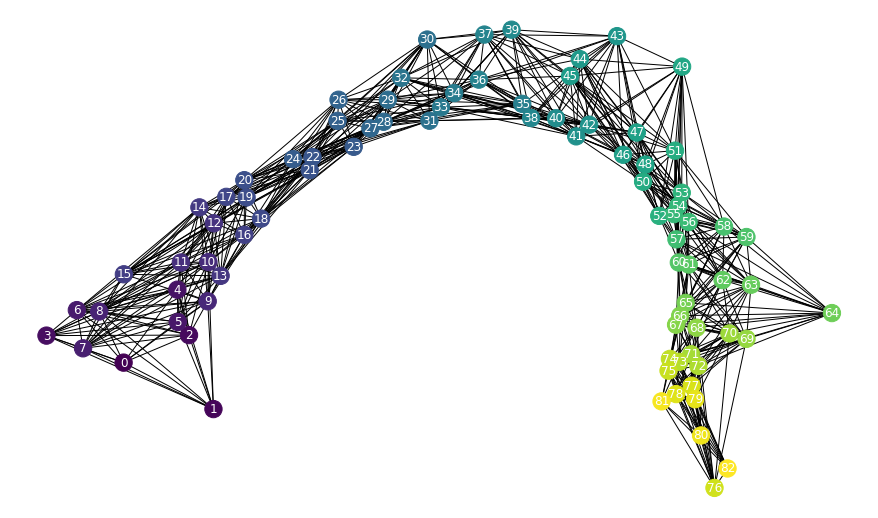

In [115]:
data=dataset[0]
visualizeGraph(data)

No. of nodes: 83
No. of edges: 687


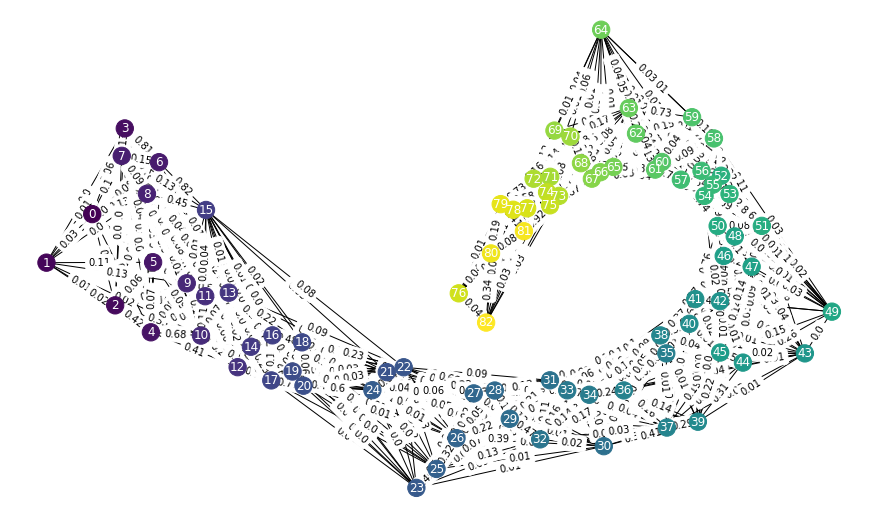

In [117]:
data=dataset[0]
visualizeGraph(data, show_edge_label=True)

In [120]:
dataset = ApolloscapeDataset(root='/', mu=10, path_of_npy_file='/trainSet2.npy', processed_file_save_path='/trainSet2_graphs.dataset')

  1%|          | 4/527 [00:00<00:15, 34.49it/s]

Processing...


100%|██████████| 527/527 [00:06<00:00, 82.42it/s] 

Done!


No. of nodes: 27
No. of edges: 197


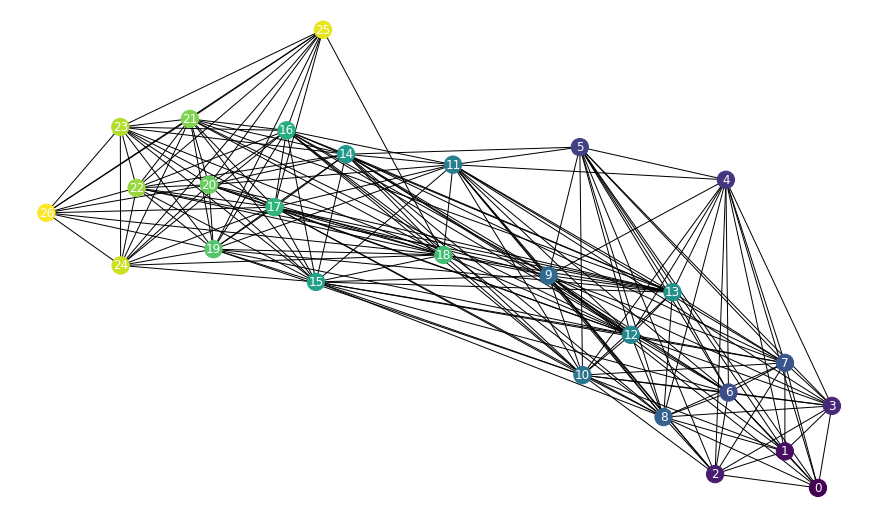

In [133]:
data=dataset[510]
visualizeGraph(data)

No. of nodes: 27
No. of edges: 197


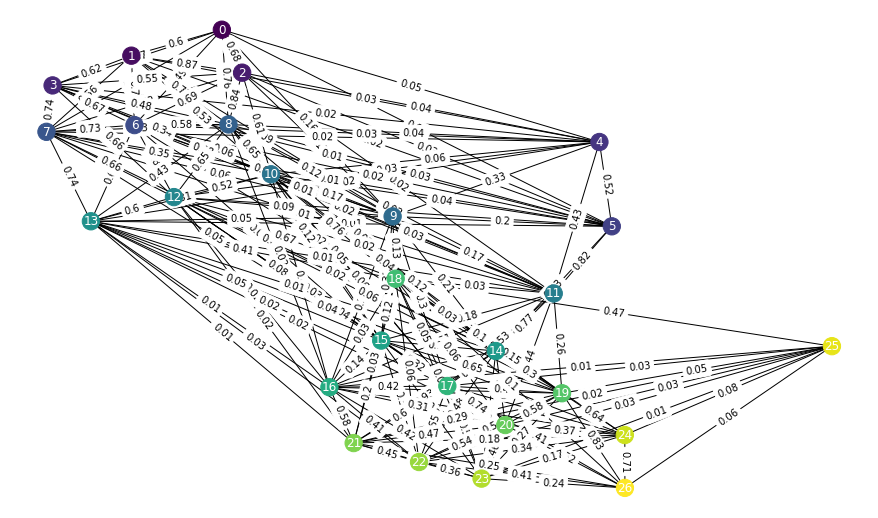

In [132]:
data=dataset[510]
visualizeGraph(data, show_edge_label=True)